# Convolutional AutoEncoder model for anomalies detection

In [1]:
# ---- utils libs ----
import numpy as np
import pandas as pd
import datetime
from typing import Optional

# --- Import functions from module.py ---
import sys
sys.path.insert(0,'..')
from module import plot_confusion_matrix, plot_activity_hist, load_dataset, load_aggregate_dataset, time_in_range, segmentDf, create_sequence, train_test_split_dataset, convertToSequenceParameters

# ---- Data Viz libs ---- 
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

# ---- ML libs ----
from sklearn.preprocessing import StandardScaler

# ---- Deep Learning libs ----
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers

## Load Dataset

In [2]:
dataset_resampled_1H = load_dataset("house1_power_blk2_labels.zip","60min")
dataset_resampled_1H = dataset_resampled_1H["mains"]
df_mains_resampled_1H = pd.DataFrame(dataset_resampled_1H)
df_mains_resampled_1H

,mains
datetime,
2016-03-06 00:00:00,473.0
2016-03-06 01:00:00,736.0
2016-03-06 02:00:00,479.0
2016-03-06 03:00:00,467.0
2016-03-06 04:00:00,610.0
...,...
2016-05-07 18:00:00,1413.0
2016-05-07 19:00:00,1608.0
2016-05-07 20:00:00,1116.0


In [3]:
dataset_resampled_1H_h2 = load_dataset("house2_power_blk1_labels.zip","60min")
dataset_resampled_1H_h2 = dataset_resampled_1H_h2["mains"]
df_mains_resampled_1H_h2 = pd.DataFrame(dataset_resampled_1H_h2)
df_mains_resampled_1H_h2

,mains
datetime,
2017-09-12 23:00:00,103.0
2017-09-13 00:00:00,112.0
2017-09-13 01:00:00,211.0
2017-09-13 02:00:00,108.0
2017-09-13 03:00:00,207.0
...,...
2017-11-10 19:00:00,218.0
2017-11-10 20:00:00,672.0
2017-11-10 21:00:00,430.0


## Visualize Load Curve

In [4]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_mains_resampled_1H.index, y=df_mains_resampled_1H['mains'], name='Load Curve'))
fig.update_layout(showlegend=True, title='house1_power_blk2_labels_60min')
fig.show()

## Preprocessing

####  1/ Loads the dataset and resample timeseries
####  2/ Split a dataframe into train set and test set according to the split rate
####  3/ Standardize Data
####  4/ Construction of the dataset according to peak and off-peak hours or according to activity labels
####  5/ Creation of sequences of length T and according to the overlapping period

#### Return preprocessed ``3D-array`` ``[samples, SEQUENCE_LENGTH, features]`` (i.e sequences from the timeseries) , as required for **LSTM** network. We want our network to have memory of **10 days**, so we set ``SEQUENCE_LENGTH=10``.

#### Define Global Hyperparmètre

In [5]:
TIME_STEP = datetime.timedelta(minutes=1, seconds=30) # duration of a step in the resample dataset, originally 1 second
DURATION_TIME = datetime.timedelta(minutes=60) # duration of a sequence
OVERLAP_PERIOD_PERCENT = 0.8 # 0.5 <=> 50% overlapping
TIMEFRAMES = [(datetime.time(0,0,0), datetime.time(3,0,0))]
STRATEGY = "off_peak_time" # device, off_peak_time, label 

SEQUENCE_LENGTH, OVERLAP_PERIOD = convertToSequenceParameters(TIME_STEP, DURATION_TIME, OVERLAP_PERIOD_PERCENT)

print("\t\tValeur choisie \t Equivalent sequence\nTimestep : \t {}\nDuration :\t {} \t -->  {} \nOverlap :\t {} \t -->  {}".format(TIME_STEP, DURATION_TIME, SEQUENCE_LENGTH, OVERLAP_PERIOD_PERCENT, OVERLAP_PERIOD))

LEARNING_RATE = 0.001
LEARNING_RATE_FT = 0.0001

NITER = 50
NITER_FT = 100

LAYERS_FT = 0,2

		Valeur choisie 	 Equivalent sequence
Timestep : 	 0:01:30
Duration :	 1:00:00 	 -->  40 
Overlap :	 0.8 	 -->  32


In [6]:
def preprocessing(timeframes: list
                  ,sequence_length: int, overlap_period: int
                  ,resample_period :Optional[str]=None
                  ,use_labels :Optional[bool]=False
                  ,strategy :Optional[str] = "off_peak_time" 
                  ,split_rate :Optional[float]=0.2
                  ,dataset_name:Optional[str] = "house1_power_blk2_labels.zip") -> np.array:
    """
    1/ Loads the dataset and resample timeseries
    2/ Split a dataframe into train set and test set according to the split rate
    3/ Standardize Data
    4/ Construction of the dataset according to peak and off-peak hours 
    or according to activity labels
    5/ Creation of sequences of length T and according to the overlapping period
    
    Args:
        - resample_period: (optional) the reasmple period, if None the default period of 1 second will be used
        - timeframes: list of tuples indicating the periods of the day ex: timeframes = [(datetime.time(10,0,0), datetime.time(6,0,0)), (datetime.time(12,0,0), datetime.time(13,0,0))
        - use_labels: (False by default) use the activities labels
        - sequence_length: length of the sequence
        - overlap_period: overlap the sequences of timeseries
        - device_approach: the aggregated load curve of the devices which, when in operation, do not allow us to predict an activity 
        - split_rate: Rate of the test set size
        - device_strategy: use inactive devices base load curve
        - dataset_name: the name of the dataset file to use
    Returns: 
        - list of prepocessed 3D-array [samples, sequence_length, features] (i.e sequences from the timeseries) 
    """
        
    # load dataset with labels and resampled timeseries
    df_resampled = load_dataset(dataset_name, resample_period)
    
    # split dataframe into train set and test set
    train_df, test_df = train_test_split_dataset(df_resampled)
    
    # Standardize Data
    scaler = StandardScaler()
    scaler_train = scaler.fit(train_df[['mains']])
    
    train_df['mains'] = scaler_train.transform(train_df[['mains']])
    test_df['mains'] = scaler_train.transform(test_df[['mains']])
        
    # ---- TEST SEQUENCES ----
    X_sequences_test, y_sequences_test = create_sequence(test_df, sequence_length, overlap_period)
    
    if STRATEGY == "device":
        # load dataset with labels and resampled timeseries
        df_resampled_with_labels = load_dataset("house1_power_blk2_labels.zip", resample_period)
        # load dataset with inactive devices
        df_resampled_devices_inactive = load_aggregate_dataset("house1_power_blk2.zip", "inactive_house2", resample_period)
        activity = df_resampled_with_labels["activity"]
        df_resampled_device = df_resampled_devices_inactive.join(activity)
        df_resampled_device['mains'] = scaler_train.transform(df_resampled_device[['mains']])
        
        # --- TRAIN SEQUENCES ----
        X_sequence_train_device, y_sequence_train_device = create_sequence(df_resampled_device, sequence_length, overlap_period)
        
        return df_resampled_device, test_df, X_sequence_train_device, y_sequence_train_device, X_sequences_test, y_sequences_test
    
    
    if STRATEGY == "label":
        # load dataset with labels and resampled timeseries
        df_resampled_with_labels = load_dataset("house1_power_blk2_labels.zip", resample_period)
        df_resampled_with_labels = df_resampled_with_labels[df_resampled_with_labels.activity == 0]
        df_resampled_with_labels['mains'] = scaler_train.transform(df_resampled_with_labels[['mains']])
        
        # --- TRAIN SEQUENCES ----
        X_sequence_train_label, y_sequence_train_label = create_sequence(df_resampled_with_labels, sequence_length, overlap_period)
        
        return df_resampled_with_labels, test_df, X_sequence_train_label, y_sequence_train_label, X_sequences_test, y_sequences_test
    
    
    if STRATEGY == "off_peak_time":
        # --- TRAIN SEQUENCES ----
        # Construction of the dataset according to peak and off-peak hours 
        list_df_train = segmentDf(train_df, timeframes = timeframes)

        # init 3D-array [samples, sequence_length, features]
        first_df_train = list_df_train[0]
        list_X_sequence_train, list_y_sequence_train = create_sequence(first_df_train, sequence_length, overlap_period)
        list_df_train.pop(0) # delete the first element of the list of train dataframes

        # Creation of sequences of length T and according to the overlapping period
        for df_train_ in list_df_train:
            X_sequences_train, y_sequences_train = create_sequence(df_train_, sequence_length, overlap_period)
            list_X_sequence_train = np.append(list_X_sequence_train, X_sequences_train, axis = 0)
            list_y_sequence_train = np.append(list_y_sequence_train, y_sequences_train, axis = 0)
        
        return list_df_train, train_df, test_df, list_X_sequence_train, list_y_sequence_train, X_sequences_test, y_sequences_test

In [7]:
if STRATEGY == "device":
    resampled_device_train_df_h1, test_df_h1, X_train_h1, y_train_h1, X_test_h1, y_test_h1 = preprocessing( 
                              timeframes = TIMEFRAMES
                              ,sequence_length = SEQUENCE_LENGTH
                              ,overlap_period = OVERLAP_PERIOD
                              ,resample_period = TIME_STEP
                              ,strategy = STRATEGY
                              ,dataset_name="house1_power_blk2_labels.zip")

    resampled_device_train_df_h2, test_df_h2, X_train_h2, y_train_h2, X_test_h2, y_test_h2 = preprocessing( 
                              timeframes = TIMEFRAMES
                              ,sequence_length = SEQUENCE_LENGTH
                              ,overlap_period = OVERLAP_PERIOD
                              ,resample_period = TIME_STEP
                              ,strategy = STRATEGY
                              ,dataset_name="house2_power_blk1_labels.zip")
    
if STRATEGY == "label":
    resampled_label_train_df_h1, test_df_h1, X_train_h1, y_train_h1, X_test_h1, y_test_h1 = preprocessing( 
                              timeframes = TIMEFRAMES
                              ,sequence_length = SEQUENCE_LENGTH
                              ,overlap_period = OVERLAP_PERIOD
                              ,resample_period = TIME_STEP
                              ,strategy = STRATEGY
                              ,dataset_name="house1_power_blk2_labels.zip")

    resampled_label_train_df_h2, test_df_h2, X_train_h2, y_train_h2, X_test_h2, y_test_h2 = preprocessing( 
                              timeframes = TIMEFRAMES
                              ,sequence_length = SEQUENCE_LENGTH
                              ,overlap_period = OVERLAP_PERIOD
                              ,resample_period = TIME_STEP
                              ,strategy = STRATEGY
                              ,dataset_name="house2_power_blk1_labels.zip")
    
if STRATEGY == "off_peak_time":
    list_df_train_h1, train_df_h1, test_df_h1, X_train_h1, y_train_h1, X_test_h1, y_test_h1 = preprocessing( 
                              timeframes = TIMEFRAMES
                              ,sequence_length = SEQUENCE_LENGTH
                              ,overlap_period = OVERLAP_PERIOD
                              ,resample_period = TIME_STEP
                              ,strategy = STRATEGY
                              ,dataset_name="house1_power_blk2_labels.zip")
    list_df_train_h2, train_df_h2, test_df_h2, X_train_h2, y_train_h2, X_test_h2, y_test_h2 = preprocessing( 
                              timeframes = TIMEFRAMES
                              ,sequence_length = SEQUENCE_LENGTH
                              ,overlap_period = OVERLAP_PERIOD
                              ,resample_period = TIME_STEP
                              ,strategy = STRATEGY
                              ,dataset_name="house2_power_blk1_labels.zip")

/tmp/ipykernel_178797/3872935662.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_178797/3872935662.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/mnt/data/Documents/Cours Télécom/INFMDI780 - Projet Fil Rouge/Activity_Detection_From_Electrical_Consumption_Load_Curves/Convolutional Auto Encoder/../module.py:453: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [8]:
def get_scores(X_train, X_test, y_test, test_df, model):
    # Get train MAE loss.
    X_train_pred = model.predict(X_train)
    train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

    # Get reconstruction loss threshold.
    threshold = np.max(train_mae_loss)

    df_test_value = test_df["mains"]

    # Get test MAE loss.
    X_test_pred = model.predict(X_test)
    test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
    test_mae_loss = test_mae_loss.reshape((-1))

    # Get reconstruction loss threshold.
    threshold = np.max(train_mae_loss)
    print("Reconstruction error threshold: ", threshold)
    anomalies = test_mae_loss > threshold

    # get index of each sequence considered as an anomaly
    sequences_anomalies_idx = list()
    for i in range(len(anomalies)):
        if anomalies[i] == True:
            sequences_anomalies_idx.append(i)

    # get index of each data point from X_test considered as an anomaly 
    data_anomalies_idx = list()
    for elm in sequences_anomalies_idx:
        for i in range(SEQUENCE_LENGTH):
            data_idx = y_test[elm][i][2] 
            data_anomalies_idx.append(data_idx)

    print("Number of data points considered as anomalies (= activity) : ", len(data_anomalies_idx))

    df_subset = df_test_value.iloc[data_anomalies_idx]
    df_subset = df_subset[df_subset.values > threshold]

    df_subset_pred = pd.DataFrame(df_subset)
    df_subset_pred["activity_pred"] = 1

    fig, ax = plt.subplots()

    plot_activity_hist(df_subset_pred['activity_pred'], figsize=(12, 6), alpha=0.5, label='predictions', ax=ax) 
    plot_activity_hist(test_df["activity"], figsize=(12, 6), alpha=0.5, label='truth', color='tab:orange', ax=ax)
    plt.show()

    test_df_eval = test_df.copy()
    test_df_eval["activity"] = 0
    idx_anom = df_subset_pred.index
    test_df_eval.loc[idx_anom, "activity"] = 1

    plot_confusion_matrix(test_df["activity"].values, test_df_eval['activity'].values)
    plt.show()

In [9]:
if STRATEGY == "device":
    print("---- train DataFrame Device shape ----")
    print(resampled_device_train_df_h1.shape)
    print(resampled_device_train_df_h2.shape)
    
if STRATEGY == "label":
    print("---- train DataFrame Label shape ----")
    print(resampled_label_train_df_h1.shape)
    print(resampled_label_train_df_h2.shape)
    
if STRATEGY == "off_peak_time":
    print("---- train DataFrame Off-Peak-Time shape ----")
    print(train_df_h1.shape)
    print(train_df_h2.shape)

---- train DataFrame Off-Peak-Time shape ----
(48352, 3)
(45344, 3)


In [10]:
print("---- test DataFrame shape ----")
print(test_df_h1.shape)
print(test_df_h2.shape)

---- test DataFrame shape ----
(12088, 3)
(11336, 3)


### Visualize ``train_df``

In [11]:
if STRATEGY == "device":
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=resampled_device_train_df_h1.index, y=resampled_device_train_df_h1['mains'], name='Load Curve'))
    fig.update_layout(showlegend=True, title='resampled_device_train_df')
    fig.show()
    
if STRATEGY == "label":
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=resampled_label_train_df_h1.index, y=resampled_label_train_df_h1['mains'], name='Load Curve'))
    fig.update_layout(showlegend=True, title='resampled_label_train_df')
    fig.show()
    
if STRATEGY == "off_peak_time":
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train_df_h1.index, y=train_df_h1['mains'], name='Load Curve'))
    fig.update_layout(showlegend=True, title='train_df')
    fig.show()

### Visualize ``list_df_train``

In [12]:
if STRATEGY == "off_peak_time":
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list_df_train_h1[6].index, y=list_df_train_h1[6]['mains'], name='Load Curve'))
    fig.update_layout(showlegend=True, title='list_df_train'+str(2))
    fig.show()

### Verify the shape of the sequence

In [13]:
print("---- X_train sequence shape ----")
print(X_train_h1.shape)
print(X_train_h2.shape)

print("\n---- y_train sequence shape ----")
print(y_train_h1.shape)
print(y_train_h2.shape)

print("\n\n---- X_test sequence shape ----")
print(X_test_h1.shape)
print(X_test_h2.shape)

print("\n---- y_test sequence shape ----")
print(y_test_h1.shape)
print(y_test_h2.shape)

---- X_train sequence shape ----
(561, 40, 1)
(528, 40, 1)

---- y_train sequence shape ----
(561, 40, 3)
(528, 40, 3)


---- X_test sequence shape ----
(1506, 40, 1)
(1412, 40, 1)

---- y_test sequence shape ----
(1506, 40, 3)
(1412, 40, 3)


## Build a model

We will build a convolutional reconstruction autoencoder model. The model will take input of shape (``batch_size``, ``sequence_length``, ``num_features``) and return output of the same shape. In this case, ``sequence_length`` is **10** and ``num_features`` is **1**.

First we'll train a model on house 1.

In [14]:
model_h1 = keras.Sequential(
    [
        layers.Input(shape=(X_train_h1.shape[1], X_train_h1.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=4, padding="same"),
    ]
)
model_h1.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss="mse")
model_h1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 32)            256       
                                                                 
 dropout (Dropout)           (None, 20, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 20, 16)           1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 20, 16)            0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 40, 32)           3616      
 ranspose)                                              

2022-05-05 17:50:08.897813: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 17:50:08.903110: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 17:50:08.903291: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 17:50:08.903800: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

### Train the model

Please note that we are using ``X_train`` as both the input and the target since this is a reconstruction model.

In [15]:
history = model_h1.fit(
    X_train_h1,
    X_train_h1,
    epochs=NITER,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50


2022-05-05 17:50:10.418985: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


4/4 [==============================] - 2s 102ms/step - loss: 0.3736 - val_loss: 0.3141
Epoch 2/50
4/4 [==============================] - 0s 8ms/step - loss: 0.3202 - val_loss: 0.2484
Epoch 3/50
4/4 [==============================] - 0s 9ms/step - loss: 0.2398 - val_loss: 0.1506
Epoch 4/50
4/4 [==============================] - 0s 9ms/step - loss: 0.1354 - val_loss: 0.0487
Epoch 5/50
4/4 [==============================] - 0s 10ms/step - loss: 0.0797 - val_loss: 0.0593
Epoch 6/50
4/4 [==============================] - 0s 11ms/step - loss: 0.0924 - val_loss: 0.0318
Epoch 7/50
4/4 [==============================] - 0s 9ms/step - loss: 0.0621 - val_loss: 0.0331
Epoch 8/50
4/4 [==============================] - 0s 9ms/step - loss: 0.0650 - val_loss: 0.0394
Epoch 9/50
4/4 [==============================] - 0s 9ms/step - loss: 0.0648 - val_loss: 0.0315
Epoch 10/50
4/4 [==============================] - 0s 9ms/step - loss: 0.0580 - val_loss: 0.0254
Epoch 11/50
4/4 [=============================

### Evaluation of the model

Let's plot training and validation loss to see how the training went.

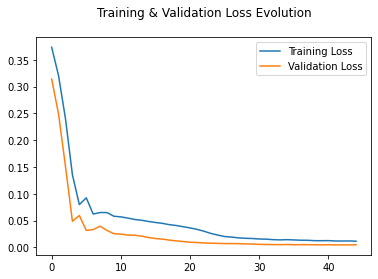

In [16]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Training & Validation Loss Evolution\n")
plt.show()

### Detecting anomalies

We will detect anomalies by determining how well our model can reconstruct the input data.

We'll test our models against both houses

Reconstruction error threshold:  0.26472843483617686
Number of data points considered as anomalies (= activity) :  4240


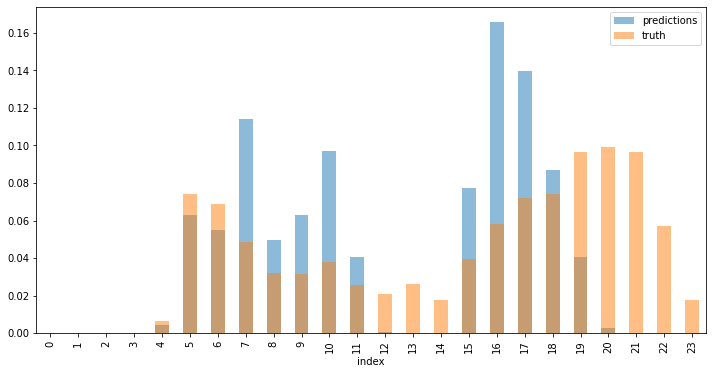

Score f_beta : 47.578%
Score accuracy : 59.927%


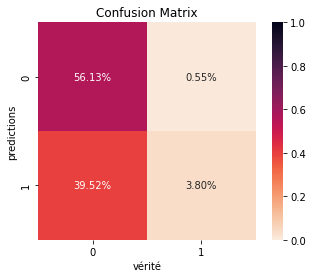

In [17]:
get_scores(X_train_h1, X_test_h1, y_test_h1, test_df_h1, model_h1)

Reconstruction error threshold:  0.20477186723237023
Number of data points considered as anomalies (= activity) :  9680


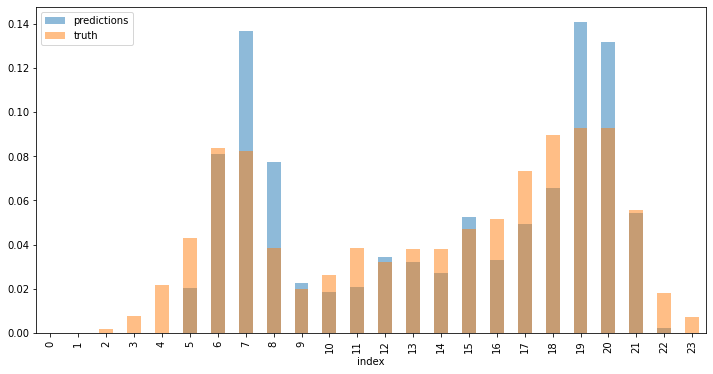

Score f_beta : 68.705%
Score accuracy : 69.637%


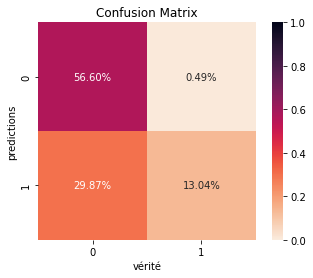

In [18]:
get_scores(X_train_h2, X_test_h2, y_test_h2, test_df_h2, model_h1)

### Fune-tine the model on house 2

Epoch 1/100
4/4 [==============================] - 0s 61ms/step - loss: 0.0082 - val_loss: 0.0035
Epoch 2/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0075 - val_loss: 0.0030
Epoch 3/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0069 - val_loss: 0.0026
Epoch 4/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0065 - val_loss: 0.0023
Epoch 5/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0062 - val_loss: 0.0021
Epoch 6/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0059 - val_loss: 0.0020
Epoch 7/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0056 - val_loss: 0.0020
Epoch 8/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0057 - val_loss: 0.0020
Epoch 9/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0055 - val_loss: 0.0020
Epoch 10/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0055 - val_loss: 0.0020
Epoch 11/100
4/4 [==========

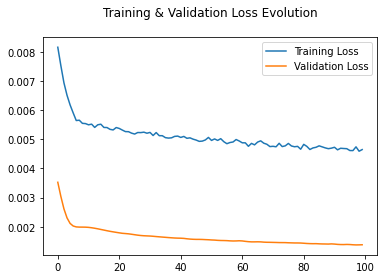

In [19]:
# on modifie la valeur du learning rate
K.set_value(model_h1.optimizer.learning_rate, LEARNING_RATE_FT)
# seules les layers entre LAYERS_FT[0] et LAYERS_FT[1] deviennent entrainable
for layer in model_h1.layers[LAYERS_FT[0]:LAYERS_FT[1]+1]:
    layer.trainable = False

history = model_h1.fit(
    X_train_h2,
    X_train_h2,
    epochs=NITER_FT,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Training & Validation Loss Evolution\n")
plt.show()

Reconstruction error threshold:  0.33890929047188034
Number of data points considered as anomalies (= activity) :  3480


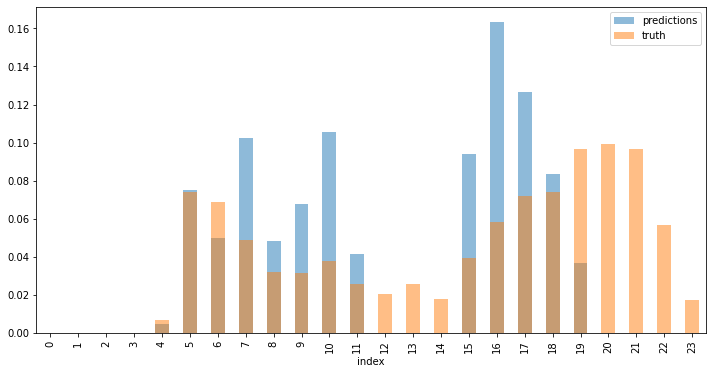

Score f_beta : 45.027%
Score accuracy : 59.216%


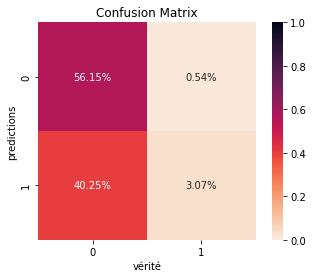

In [20]:
get_scores(X_train_h1, X_test_h1, y_test_h1, test_df_h1, model_h1)

Reconstruction error threshold:  0.16282319210303245
Number of data points considered as anomalies (= activity) :  10440


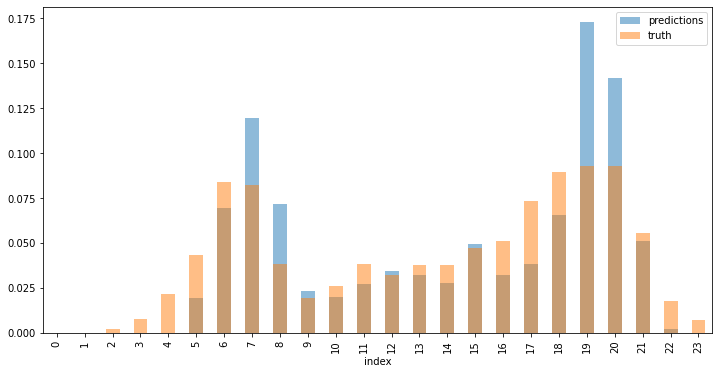

Score f_beta : 72.061%
Score accuracy : 71.974%


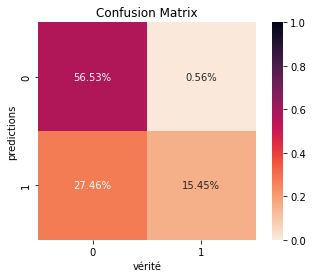

In [21]:
get_scores(X_train_h2, X_test_h2, y_test_h2, test_df_h2, model_h1)

## Fit a model on house 2

In [22]:
model_h2 = keras.Sequential(
    [
        layers.Input(shape=(X_train_h2.shape[1], X_train_h2.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=4, padding="same"),
    ]
)
model_h2.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss="mse")
model_h2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 20, 32)            256       
                                                                 
 dropout_2 (Dropout)         (None, 20, 32)            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 10, 16)            3600      
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 20, 16)           1808      
 ranspose)                                                       
                                                                 
 dropout_3 (Dropout)         (None, 20, 16)            0         
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 40, 32)           3616      
 ranspose)                                            

### Train the model

Please note that we are using ``X_train`` as both the input and the target since this is a reconstruction model.

In [23]:
history = model_h2.fit(
    X_train_h2,
    X_train_h2,
    epochs=NITER,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
4/4 [==============================] - 1s 52ms/step - loss: 0.1072 - val_loss: 0.0719
Epoch 2/50
4/4 [==============================] - 0s 9ms/step - loss: 0.0669 - val_loss: 0.0297
Epoch 3/50
4/4 [==============================] - 0s 9ms/step - loss: 0.0265 - val_loss: 0.0150
Epoch 4/50
4/4 [==============================] - 0s 9ms/step - loss: 0.0276 - val_loss: 0.0150
Epoch 5/50
4/4 [==============================] - 0s 9ms/step - loss: 0.0193 - val_loss: 0.0104
Epoch 6/50
4/4 [==============================] - 0s 9ms/step - loss: 0.0170 - val_loss: 0.0134
Epoch 7/50
4/4 [==============================] - 0s 9ms/step - loss: 0.0183 - val_loss: 0.0117
Epoch 8/50
4/4 [==============================] - 0s 9ms/step - loss: 0.0157 - val_loss: 0.0089
Epoch 9/50
4/4 [==============================] - 0s 9ms/step - loss: 0.0145 - val_loss: 0.0088
Epoch 10/50
4/4 [==============================] - 0s 9ms/step - loss: 0.0141 - val_loss: 0.0079
Epoch 11/50
4/4 [=====================

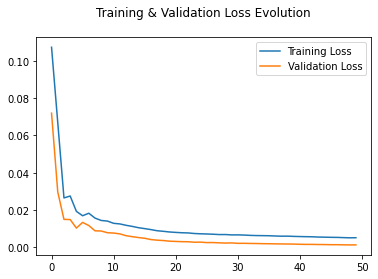

In [24]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Training & Validation Loss Evolution\n")
plt.show()

### Detecting anomalies

We will detect anomalies by determining how well our model can reconstruct the input data.

Reconstruction error threshold:  0.6524115548724787
Number of data points considered as anomalies (= activity) :  3400


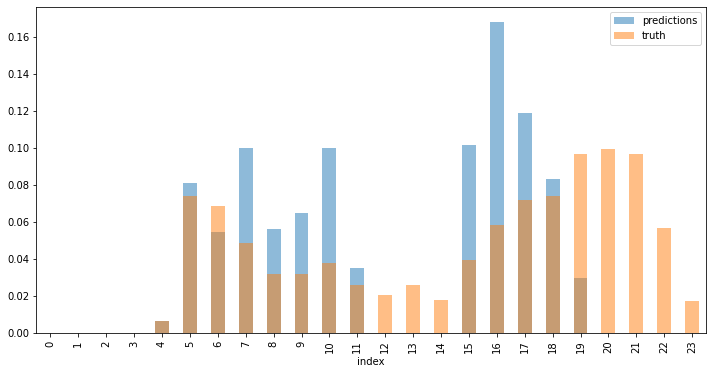

Score f_beta : 43.723%
Score accuracy : 58.877%


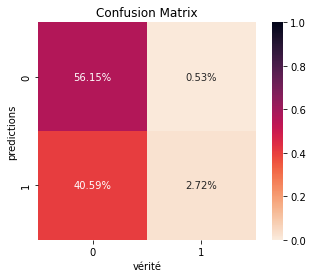

In [25]:
get_scores(X_train_h1, X_test_h1, y_test_h1, test_df_h1, model_h2)

Reconstruction error threshold:  0.1582423601621903
Number of data points considered as anomalies (= activity) :  22760


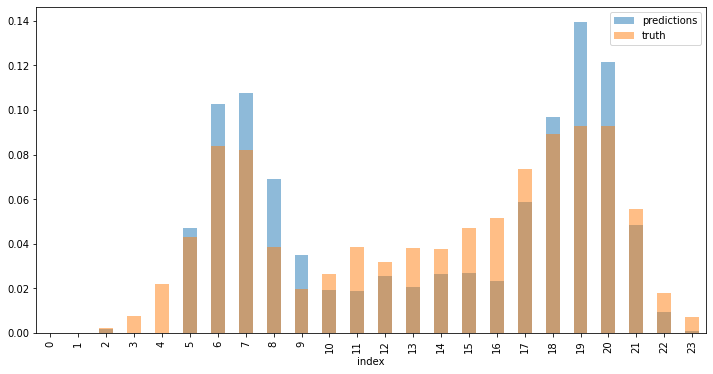

Score f_beta : 77.796%
Score accuracy : 76.994%


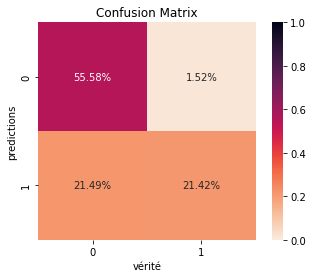

In [26]:
get_scores(X_train_h2, X_test_h2, y_test_h2, test_df_h2, model_h2)

### Fune-tine the model on house 1

Epoch 1/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0365 - val_loss: 0.0078
Epoch 2/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0328 - val_loss: 0.0049
Epoch 3/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0329 - val_loss: 0.0050
Epoch 4/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0326 - val_loss: 0.0048
Epoch 5/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0313 - val_loss: 0.0057
Epoch 6/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0314 - val_loss: 0.0060
Epoch 7/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0310 - val_loss: 0.0052
Epoch 8/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0305 - val_loss: 0.0046
Epoch 9/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0307 - val_loss: 0.0045
Epoch 10/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0301 - val_loss: 0.0046
Epoch 11/100
4/4 [=====

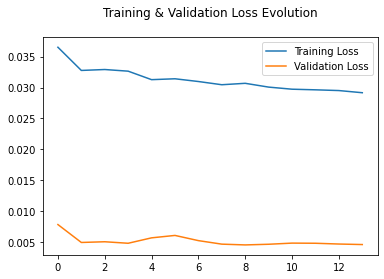

In [27]:
# on modifie la valeur du learning rate
K.set_value(model_h2.optimizer.learning_rate, LEARNING_RATE_FT)
# seules les layers entre LAYERS_FT[0] et LAYERS_FT[1] deviennent entrainable
for layer in model_h2.layers[LAYERS_FT[0]:LAYERS_FT[1]+1]:
    layer.trainable = False

history = model_h2.fit(
    X_train_h1,
    X_train_h1,
    epochs=NITER_FT,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Training & Validation Loss Evolution\n")
plt.show()

Reconstruction error threshold:  0.5998732044336685
Number of data points considered as anomalies (= activity) :  3440


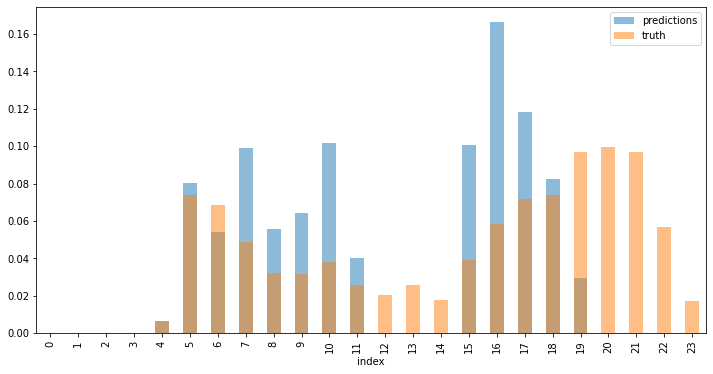

Score f_beta : 43.787%
Score accuracy : 58.893%


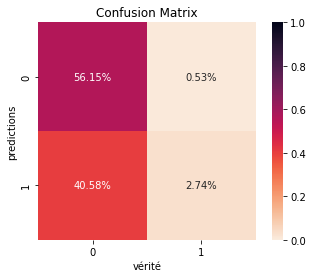

In [28]:
get_scores(X_train_h1, X_test_h1, y_test_h1, test_df_h1, model_h2)

Reconstruction error threshold:  0.15711216404685197
Number of data points considered as anomalies (= activity) :  21720


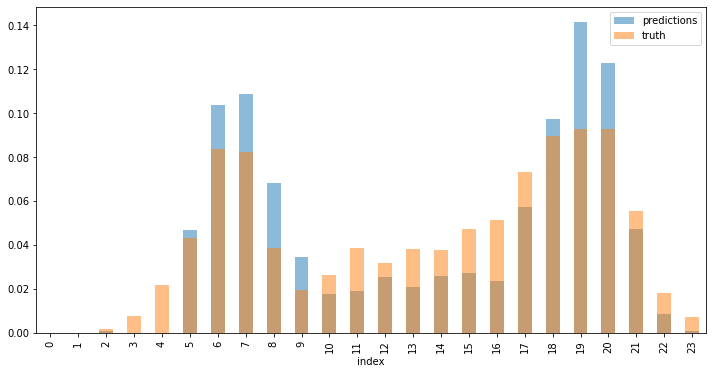

Score f_beta : 77.741%
Score accuracy : 76.941%


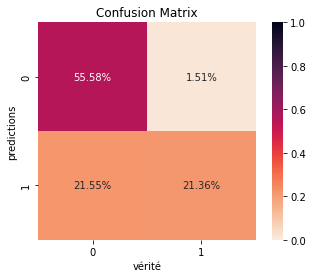

In [29]:
get_scores(X_train_h2, X_test_h2, y_test_h2, test_df_h2, model_h2)